In [1]:
# 6-11 프로젝트
!ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


In [8]:
#1. 데이터 준비와 확인

import pandas as pd

import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
# 데이터셋 내 문장 길이 분포

print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

NameError: name 'X_train' is not defined

In [ ]:
# 1. 데이터의 중복 제거 :  train_data.drop_duplicates(subset=['document'], inplace=True)
# 2. Nan 결측치 제거 :  train_data = train_data.dropna(how = 'any') 
# 3. 한국어 토크나이저로 토큰화 : from konlpy.tag import Mecab,  temp_X = tokenizer.morphs(sentence) 
# 4. 불용어(Stopwords) 제거 :  temp_X = [word for word in temp_X if not word in stopwords]
# 5. 사전word_to_index 구성 
# 6. 텍스트 스트링을 사전 인덱스 스트링으로 변환 
# 7. X_train, y_train, X_test, y_test, word_to_index 리턴

In [10]:
#2. 데이터로더 구성

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()   # numpy배열 하나로 합하기
    counter = Counter(words)
    counter = counter.most_common(10000-4) # 데이터 개수가 많은 순서로 정렬된 배열 리턴, k=4로 4개까지 리턴하는 데이터를 얻음
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 사전 구성
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [11]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [12]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])     # '<PAD>'  출력
print(index_to_word[1])    #'<BOS>' 출력
print(index_to_word[2])    #'<UNK>' 출력
print(index_to_word[3])    #'<UNUSED>' 출력


<PAD>
<BOS>
<UNK>
<UNUSED>


In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [14]:
decoded_sentences = get_decoded_sentences(X_train, index_to_word)
print(decoded_sentences[0:5])

['더 빙 . . 진짜 짜증 나 네요 목소리', '. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나', '재 <UNUSED>', '이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정', '익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNUSED> <UNUSED> 너무나 이뻐 보였 다']


In [15]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [16]:
# 모델 구성을 위한 데이터 분석 및 가공
# 3-1 데이터셋 내 문장 길이 분포
# 3-2 적절한 최대 문장 길이 지정
# 3-3 keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [17]:
# pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하기

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [18]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가하기 : 문장에 앞에 0을 채워 넣는것이 더 좋은 분석이 된다고 해서 앞에 0으로~

In [19]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)     
X_train[0]

(146182, 41)


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

In [20]:
# model 훈련 전에, 훈련용 데이터셋 146,182건 중 20%를 분리하여 검증셋(validation set)으로 사용

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                          y_train,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [21]:
# model 학습1 - RNN 이용하여 분석하기

vocab_size = 146182  # 어휘 사전의 크기입니다(74844개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용. 이때 LSTM state 벡터의 차원수는 2로 함
model.add(keras.layers.Dense(2, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

# 오류 발생으로 진행이 어려움, GPU의 용량 부족이라는데... OOM을 방지하는 가장 좋은 방법은 1번인데 진행이 안됨 =>껐다가 다시 실행하니 해결

# 1. Batch Size를 줄인다.

# 2. 이미지 크기를 줄인다.

#3. GPU의 Memory를 늘린다.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          5993462   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1600      
_________________________________________________________________
dense (Dense)                (None, 2)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 5,995,083
Trainable params: 5,995,083
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
from keras.callbacks import EarlyStopping   # earlystopping을 이용해서 과적합을 방지
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)


In [23]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)
#  loss: 0.1788 - accuracy: 0.9333 - val_loss: 0.4330 - val_accuracy: 0.8434  Epoch 00014: early stopping

Epoch 1/20
229/229 [==============================] - 5s 10ms/step - loss: 0.4583 - accuracy: 0.7971 - val_loss: 0.3623 - val_accuracy: 0.8441
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3323 - accuracy: 0.8603 - val_loss: 0.3521 - val_accuracy: 0.8468
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3115 - accuracy: 0.8693 - val_loss: 0.3513 - val_accuracy: 0.8469
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2954 - accuracy: 0.8780 - val_loss: 0.3505 - val_accuracy: 0.8480
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2816 - accuracy: 0.8840 - val_loss: 0.3536 - val_accuracy: 0.8475
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2684 - accuracy: 0.8912 - val_loss: 0.3579 - val_accuracy: 0.8492
Epoch 7/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2563 - accuracy: 0.8966 - val_loss: 0.3623 - val_accuracy: 0.8477
Epoch

In [24]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4342 - accuracy: 0.8402
[0.43419715762138367, 0.8402262330055237]


In [25]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


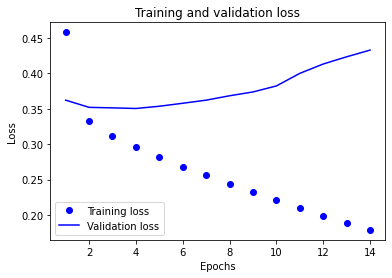

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# training loss는 epoch 진행되면서 지속적으로 감소, validation loss는 증가, 과대적합을 보임,  이에 따라 학습을 중단, 
# validation dataset 또한 test dataset을 완벽히 표현하지는 못하기 때문에 validation loss가 최소가 되는 시점이 test loss가 최소가 되는 시점과 정확히 일치하지는 않을 수도 있다.
# 여기에선 데이터셋의 수가 많아서 과적합을 막기 위한 earlystopping을 수행하여 11번째 epoch에서 멈춘 것도 영향이 있을 것 같다.

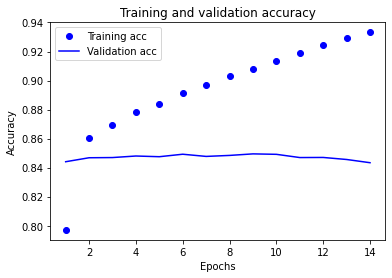

In [27]:
plt.clf()   # 그림을 초기화 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# epoch 진행될 수록 훈련데이터의 정확도는 증가, 검증데이터 정확도는 일정, 약간 감소, 과대적합 경향 있음

In [28]:
#  model 학습2. 1-D Convolution Neural Network(1-D CNN)를 사용

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))  # 시간적 데이터에 대한 평균 풀링
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())  # 시간적 데이터에 대한 글로벌 최대값 풀링 작업.
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          5993462   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)
# - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.9018 - val_accuracy: 0.8257 , Epoch 00013: early stopping

Epoch 1/20
229/229 [==============================] - 13s 8ms/step - loss: 0.4782 - accuracy: 0.7637 - val_loss: 0.3666 - val_accuracy: 0.8390
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3169 - accuracy: 0.8656 - val_loss: 0.3448 - val_accuracy: 0.8512
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2729 - accuracy: 0.8882 - val_loss: 0.3437 - val_accuracy: 0.8523
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2305 - accuracy: 0.9093 - val_loss: 0.3651 - val_accuracy: 0.8504
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1828 - accuracy: 0.9324 - val_loss: 0.4022 - val_accuracy: 0.8463
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1376 - accuracy: 0.9524 - val_loss: 0.4478 - val_accuracy: 0.8422
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1023 - accuracy: 0.9666 - val_loss: 0.5176 - val_accuracy: 0.8367
Epoch

In [31]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9030 - accuracy: 0.8237
[0.9030150175094604, 0.8236873745918274]


In [32]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


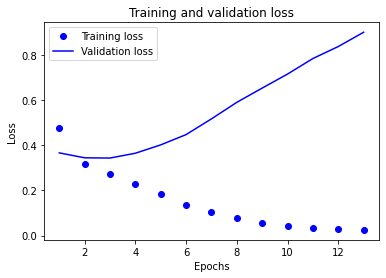

In [33]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# 2번째 에포크 이후  training loss와 validation loss의  차이가 커지며 과대적합 현상이 나타나고 있다. 

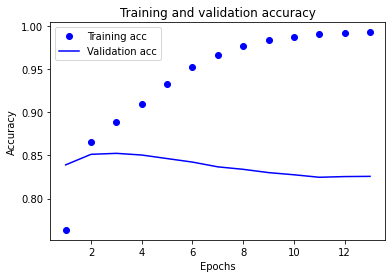

In [34]:
plt.clf()   # 그림을 초기화 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
#model 학습3. GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 생각

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)
#   loss: 0.6900 - accuracy: 0.5355 - val_loss: 0.6908 - val_accuracy: 0.5330

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.6922 - accuracy: 0.5192 - val_loss: 0.6918 - val_accuracy: 0.5207
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.6908 - accuracy: 0.5308 - val_loss: 0.6912 - val_accuracy: 0.5298
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.6904 - accuracy: 0.5340 - val_loss: 0.6910 - val_accuracy: 0.5298
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.6902 - accuracy: 0.5347 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.6902 - accuracy: 0.5350 - val_loss: 0.6911 - val_accuracy: 0.5289
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.6902 - accuracy: 0.5348 - val_loss: 0.6911 - val_accuracy: 0.5321
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.6901 - accuracy: 0.5354 - val_loss: 0.6909 - val_accuracy: 0.5331
Epoch 

In [39]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6905 - accuracy: 0.5304
[0.6904522776603699, 0.5303822159767151]


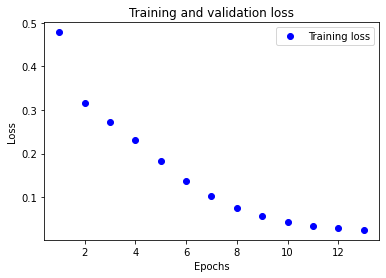

In [40]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

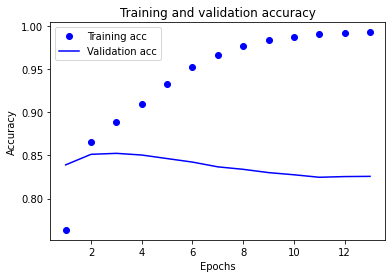

In [41]:
plt.clf()   # 그림을 초기화 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
! mkdir -p ~/aiffel/sentiment_classification/data
! pip list | grep gensim

In [ ]:
# 

## <회고>
1. Word2Vec 이용한 모델도 훈련을 해 보아야하는데.. 데이터가 upload가 되지 않아 더 이상 훈련을 수행할 수 없어 여기서 멈춤을 합니다.
2. 정확도를 보면 RNN : 0.8402, 1-D CNN : 0.8237, Globalmaxpooling : 0.5330로 Globalmaxpooling 모델의 경우 가장 낮은 정확도가 나옴.

3. 처음에 과제 진행하는 중에 오류가 발생 (GPU 용량이 부족하다는..) 퍼실님의 도움으로 재부팅으로 다시 실행한 결과 진행이 제대로 됨
4. 조금씩 이해가 되고 있으나 아직도 본인 혼자의 힘으로는 부족하여 여기저기 자료를 찾게 됨, 그게 공부이겠지요?
5. 코딩을 입력을 해 보는데 그대로 입력을 했으나 실행이 안되고 오류가 발생하는 경우도 잦음.. 좀 더 꼼꼼히 살펴보고 연습해야 할 것 같음.